In [35]:
# Data preparation for Ph.D thesis
# copy from INDICATORS_DATASET_RAW_DATA_FOR_TS-GENERATOR-PARSING.ipynb
# @author: Andres L. Suarez-Cetrulo
%config IPCompleter.greedy=True
%load_ext jupyternotify
%matplotlib inline

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [36]:
# Imports
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import os
import matplotlib.pyplot as plt

# Using TALib abstract API to create a dictionary of technical indicators to iterate later.
from talib import abstract

#### The first step is to run 1_rawdata_processing.py in the project QuantQuoteDataPreprocessing. 
- Run this for the desired ETF symbols, frequency and period (check in config.yaml).
- Move output files to the input directory of the next cell below ('path' val)

#### Then, parse the series (removing out of market hours)

In [61]:
# path = os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data','efts','30min-level',
#                     'IBEX','IBEX_[2017-01-01_to_2018-01-01]'])
sources = ['S&P500']
#date_ranges = ['[2014-12-01_to_2015-01-01]' ,'[2015-01-01_to_2016-01-01]', '[2016-01-01_to_2017-01-01]', 
#               '[2017-01-01_to_2018-01-01]', '[2018-01-01_to_2019-01-01]']
files = list()
levels = ['1min-level','5min-level','10min-level','15min-level','30min-level']
for source in sources:
    for level in levels:
        print(f'Source {source} at level {level}')
        for file in ['spy_alphavantage_2019_2020']: # ['SPY_[2017-09-22_to_2017-12-09]']:  #['spy_alphavantage_2017', 'spy_alphavantage_2018', 'spy_alphavantage_2019_2020']:
            path = os.sep.join(['C:','Users','suare','OneDrive', 'Escritorio', file])  # new - moving data across
            df = pd.read_csv(path+'.csv', sep=',')
            df.rename(columns={'date':'datetime'}, inplace=True)
            df.index = pd.to_datetime(df.datetime)
            df.drop(columns=['datetime'], inplace=True)
            df.sort_index(inplace=True)
            ohlc_dict = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}
            df = df.resample(level.split('-')[0]).agg(ohlc_dict)
    #         df = df.between_time('09:30','15:59')
            df.dropna(inplace=True)

            print(len(df))
    #         df = df.between_time('09:30','16:00')
            # if filling missing values
    #         df['volume'] = df['volume'].fillna(0)
    #         df['close'] = df['close'].ffill()
    #         df['open'] = df['open'].fillna(df['close'])
    #         df['low'] = df['low'].fillna(df['close'])
    #         df['high'] = df['high'].fillna(df['close'])
    #         df['datetime'] = df.index
            path = os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data','efts',level,
                        source,'_'.join([file, 'no_missing_data'])])
            dir_path = os.sep.join(path.split(os.sep)[:-1])
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            df.to_csv(path+'_market_hours_no_missing_data.csv', sep=';')
    #         os.remove(path+'_market_hours.csv')
            files.append(path+'_market_hours_no_missing_data.csv')
# files

Source S&P500 at level 1min-level
83690
Source S&P500 at level 5min-level
17042
Source S&P500 at level 10min-level
8633
Source S&P500 at level 15min-level
5831
Source S&P500 at level 30min-level
3024


#### Now let's define indicators, paths, and start the transformation process

In [62]:
# Creating a dictionary of technical indicators using TALib abstract API
indicators = ['sma','ema','wma','mom','stoch','macd' ,'rsi' ,'willr',
              'adosc' ,'cci','adx','aroon' ,'bbands','obv' ,'trima',
              'roc' ,'rocr','stochf','medprice','typprice','wclprice',
              'atr','macdfix','mfi' ,'sar' ,'ppo']

def get_indicator(ind: str):
    return abstract.Function(ind)

# Add as many indicators as necessary: see all indicators in https://mrjbq7.github.io/ta-lib/

In [63]:
import subprocess
# Define this to parse the CSVs to ARFF later automatically
def create_arff_file(filename, output=None):
    java_mem = '-Xmx3074m'
    filename = filename.replace('.csv', '')
    if output is None:
        output=filename
    else:
        output = output.replace('.csv', '')
    wekadev_libpath = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\lib\\weka-dev-3.7.12.jar'
    command = ['java', java_mem, '-classpath', wekadev_libpath,
               'weka.core.converters.CSVLoader', filename + '.csv', '>', output + '.arff']
    f = open(filename + '.arff', "w")
    subprocess.call(command, stdout=f)
    print('If the arff is not generated, run the next in the terminal.')
    print(str(' '.join(command)))

In [64]:
# Paths for symbols (not eft)
DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data'])
# '/Users/asuarez/Downloads'
SOURCE_PATH=DATA_PATH # +'raw\\alpha_vantage\\S&P500\\symbols\\AAPL\\'  # 'raw/alpha_vantage/'
RESULT_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output']) # +'analysis\\'+SYMBOL.lower()+'\\'

# List of dates for files to be loaded
# raw_datasets = ['aapl\\APPLE_[2018-08-01_to_2018-09-11]_5min.csv',
#                   'btc\\BITCOIN_[2019-07-01_to_2019-07-15]_5min.csv',
#                   'xrp\\RIPPLE_[2019-07-01_to_2019-08-01]_5min.csv',
#                   'efts\\5min-level\\DOWJONES\\DOWJONES_[2015-08-01_to_2015-08-31]_market_hours.csv']
raw_datasets = ['efts\\'+level+'\\DOWJONES\\DOWJONES_[2015-01-01_to_2016-01-01]_market_hours.csv']
    
filename = raw_datasets[0] # 'timeseries_created_21-10-2019' # 'timeseries_created_1571527428'
FIELD = 'close' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'

file = os.sep.join([SOURCE_PATH, filename])
RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_indicators_best_17052020.csv'])

In [65]:
# Open file
df=pd.read_csv(file, sep=';')
print(df.head())

df['close'] = df[FIELD]
df.close.head()

FileNotFoundError: [Errno 2] File b'C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\data\\efts\\30min-level\\DOWJONES\\DOWJONES_[2015-01-01_to_2016-01-01]_market_hours.csv' does not exist: b'C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\data\\efts\\30min-level\\DOWJONES\\DOWJONES_[2015-01-01_to_2016-01-01]_market_hours.csv'

In [19]:
#Add parameters to transform in TS
timeseries=['close', 'open', 'high', 'low']
#Length of the TS. How many values do we keep per serie. 
# e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
length = 5

# Add lagged times
for column in timeseries:
    #df[column+'_t']=df[column]
    for i in range(1,length):
        df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed
    #del drops the delected df column
    #del df[column]
df.head()

,datetime,open,high,low,close,volume,gap,timestamp,close_t-1,close_t-2,...,open_t-3,open_t-4,high_t-1,high_t-2,high_t-3,high_t-4,low_t-1,low_t-2,low_t-3,low_t-4
0,2015-01-02 09:30:00,178.6200,178.7300,178.5601,178.660,84826.0,0.0,1420191000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02 09:31:00,178.6800,178.7154,178.5701,178.690,19078.0,0.0,1420191060,178.660,NaN,...,NaN,NaN,178.7300,NaN,NaN,NaN,178.5601,NaN,NaN,NaN
2,2015-01-02 09:32:00,178.7099,178.8040,178.6800,178.804,12179.0,0.0,1420191120,178.690,178.660,...,NaN,NaN,178.7154,178.7300,NaN,NaN,178.5701,178.5601,NaN,NaN
3,2015-01-02 09:33:00,178.7950,178.8900,178.7700,178.890,16965.0,0.0,1420191180,178.804,178.690,...,178.62,NaN,178.8040,178.7154,178.7300,NaN,178.6800,178.5701,178.5601,NaN
4,2015-01-02 09:34:00,178.8900,178.9100,178.8300,178.870,22910.0,0.0,1420191240,178.890,178.804,...,178.68,178.62,178.8900,178.8040,178.7154,178.73,178.7700,178.6800,178.5701,178.5601


In [30]:
# all the numbers here and below assume a default time period for ta params of 10 mins averages
# change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
# in that case change as well the time tag '_10' with the corresponding one.
default_timerange=10
# Set extra timeranges for moving averages
extra_timeranges=[default_timerange/2, default_timerange, default_timerange*2, default_timerange*3]

# ###########################################
# Iterate and run list of indicators selected
# All of them produced for 25 prior mins of data 
# ###########################################
for ind in list(indicators):
    if ind not in ['adosc', 'obv', 'mfi']:  # avoiding indicators that need volume
        # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
        if ind in ['ema','sma','trima']:
            for timerange in extra_timeranges:
                df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
        elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
            df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
        # Otherwise check the list of columns and return all
        else: 
            key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
            for j in range(0,len(list(key_output.columns))):
                df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]
df.head()

,datetime,open,high,low,close,volume,gap,timestamp,close_t-1,close_t-2,...,stochf_fastd,medprice_10,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10
0,2015-01-02 09:30:00,178.6200,178.7300,178.5601,178.660,84826.0,0.0,1420191000,NaN,NaN,...,NaN,178.64505,178.650033,178.652525,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02 09:31:00,178.6800,178.7154,178.5701,178.690,19078.0,0.0,1420191060,178.660,NaN,...,NaN,178.64275,178.658500,178.666375,NaN,NaN,NaN,NaN,178.560100,NaN
2,2015-01-02 09:32:00,178.7099,178.8040,178.6800,178.804,12179.0,0.0,1420191120,178.690,178.660,...,NaN,178.74200,178.762667,178.773000,NaN,NaN,NaN,NaN,178.563206,NaN
3,2015-01-02 09:33:00,178.7950,178.8900,178.7700,178.890,16965.0,0.0,1420191180,178.804,178.690,...,NaN,178.83000,178.850000,178.860000,NaN,NaN,NaN,NaN,178.570100,NaN
4,2015-01-02 09:34:00,178.8900,178.9100,178.8300,178.870,22910.0,0.0,1420191240,178.890,178.804,...,NaN,178.87000,178.870000,178.870000,NaN,NaN,NaN,NaN,178.589294,NaN


In [31]:
def set_label(row):
    if row['close_t+1'] > row['close']: return 1
    else: return 0

# One minute ahead closing price
df['close_t+1']=df['close'].shift(-1)

# Creating label/y to be predicted / independent (predicted) feature 'y' 
df['label'] = df.apply(set_label, axis=1)
# df.drop(columns=['n_row', 'new_switch', 'cur_switch', 'current_model_id', 'new_model_id', 
#                  'weights', 'ts', 'ret_ts', 'ts_n1_pre', 'ts_n2_pre', 'ts_n1_post', 'ts_n2_post'], inplace=True)
df.dropna(inplace=True)
df.head()

,datetime,open,high,low,close,volume,gap,timestamp,close_t-1,close_t-2,...,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10,close_t+1,label
33,2015-01-02 10:03:00,178.82,179.03,178.82,179.01,23499.0,0.0,1420192980,178.78,178.83,...,178.953333,178.9675,0.120229,-0.006001,0.034851,-0.040852,179.177535,-0.011465,178.96,0
34,2015-01-02 10:04:00,179.03,179.04,178.87,178.96,10598.0,0.0,1420193040,179.01,178.78,...,178.956667,178.9575,0.125206,-0.009356,0.026010,-0.035366,179.148883,-0.019139,178.93,0
35,2015-01-02 10:05:00,178.95,178.97,178.92,178.93,2320.0,0.0,1420193100,178.96,179.01,...,178.940000,178.9375,0.117686,-0.014139,0.017980,-0.032119,179.121950,-0.027590,178.85,0
36,2015-01-02 10:06:00,178.90,178.90,178.81,178.85,20954.0,0.0,1420193160,178.93,178.96,...,178.853333,178.8525,0.117917,-0.023740,0.009636,-0.033376,179.096633,-0.032031,178.75,0
37,2015-01-02 10:07:00,178.87,178.88,178.71,178.75,14947.0,0.0,1420193220,178.85,178.93,...,178.780000,178.7725,0.123125,-0.038522,0.000004,-0.038527,179.072835,-0.038979,178.78,1


In [74]:
# Select columns for output
# columns_selected=['rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
#                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
#                  'trima_10','trima_20','trima_30',
#                  'roc_10','rocr_10','ppo_10',
#                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  'label']
# df['label'] = df['binary_label']
# columns_selected=[# 'datetime',
#                  'rsi_10','willr_10','macd_macd' ,'cci_10','mom_10',
#                  'stoch_slowk','stoch_slowd',
#                  'sma_5','sma_10','sma_20','sma_30',
#                  'wma_5','wma_10','wma_20','wma_30',
#                  'ema_5','ema_10','ema_20','ema_30',
#                  'trima_5','trima_10','trima_20','trima_30',
#                  'adx_10','bbands_upperband','bbands_middleband','bbands_lowerband',
#                  'roc_10','rocr_10','stochf_fastd','stochf_fastk',
#                  'aroon_aroondown','aroon_aroonup','medprice_10','typprice_10','wclprice_10',
#                  'atr_10','macdfix_macd','sar_10',
#                  # 'volume','volume_t-1','volume_t-2','volume_t-3','volume_t-4',
#                  # 'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  # 'high','high_t-1','high_t-2','high_t-3','high_t-4',
#                  # 'open','open_t-1','open_t-2','open_t-3','open_t-4',
#                  # 'low','low_t-1','low_t-2','low_t-3','low_t-4',
#                  # 'binary_label',
#                  'label'] #,'gap_t+1','close_t+1'] # + ['adosc_10', 'obv_10', 'mfi_10', 'ppo_10']
#    
# best pool found through indicators grid search script
columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                    'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                    'aroon_aroondown','aroon_aroonup','label']

# Export processed data
output = pd.DataFrame(df, columns=columns_selected)
output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
create_arff_file(RESULT_FILEPATH_PROCESSED) # export in ARFF

# Printing classes distributions
print("Class distribution: ")
label_zero=len(df[df['label'] == 0])
label_one=len(df[df['label'] == 1])
#print(label_zero)
#print(label_one)
print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

%notify -m "Parsing is finished"

If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\spy_alphavantage_2019_2020_no_missing_data_market_hours_no_missing_data_30min-level_indicators_11062020.csv > C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\spy_alphavantage_2019_2020_no_missing_data_market_hours_no_missing_data_30min-level_indicators_11062020.arff
Class distribution: 
0 in 0.4735785953177257%
1 in 0.5264214046822743%


<IPython.core.display.Javascript object>

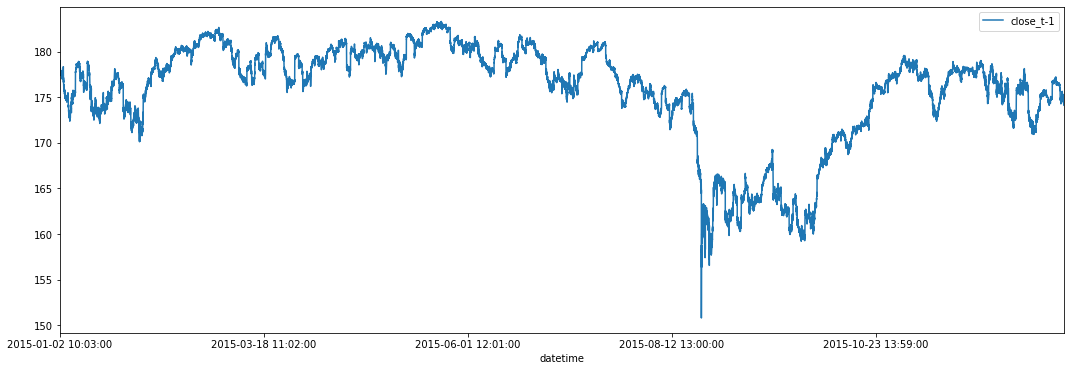

In [33]:
# Now plot close price and volume overtime.
import matplotlib.pyplot as plt
import pandas as pd

df.set_index('datetime',drop=True).plot(y=["close_t-1"], figsize=(18,6))
plt.show()

In [34]:
df.columns

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'gap',
       'timestamp', 'close_t-1', 'close_t-2', 'close_t-3', 'close_t-4',
       'open_t-1', 'open_t-2', 'open_t-3', 'open_t-4', 'high_t-1', 'high_t-2',
       'high_t-3', 'high_t-4', 'low_t-1', 'low_t-2', 'low_t-3', 'low_t-4',
       'sma_5', 'sma_10', 'sma_20', 'sma_30', 'ema_5', 'ema_10', 'ema_20',
       'ema_30', 'wma_10', 'mom_10', 'stoch_slowk', 'stoch_slowd', 'macd_macd',
       'macd_macdsignal', 'macd_macdhist', 'rsi_10', 'willr_10', 'cci_10',
       'adx_10', 'aroon_aroondown', 'aroon_aroonup', 'bbands_upperband',
       'bbands_middleband', 'bbands_lowerband', 'trima_5', 'trima_10',
       'trima_20', 'trima_30', 'roc_10', 'rocr_10', 'stochf_fastk',
       'stochf_fastd', 'medprice_10', 'typprice_10', 'wclprice_10', 'atr_10',
       'macdfix_macd', 'macdfix_macdsignal', 'macdfix_macdhist', 'sar_10',
       'ppo_10', 'close_t+1', 'label'],
      dtype='object')

In [46]:
# # Creating a dictionary of technical indicators using TALib abstract API
# indicator = {}
# # Add as many indicators as necessary: see all indicators in https://mrjbq7.github.io/ta-lib/
# indicator['sma']=abstract.Function('sma') # Simple Moving Average
# indicator['ema']=abstract.Function('ema') # Exponential Moving Average
# indicator['mom']=abstract.Function('mom') # Momentum
# indicator['stoch']=abstract.Function('stoch') # Stochastic (returns K and D)
# indicator['macd']=abstract.Function('macd') # Moving Average Convergence/Divergence
# indicator['rsi']=abstract.Function('rsi') # Relative Strength Index
# indicator['willr']=abstract.Function('willr') # Williams' %R
# indicator['adosc']=abstract.Function('adosc') # Chaikin A/D Oscillator
# indicator['cci']=abstract.Function('cci') # Commodity Channel Index

# # --- --- 

# # extra columns
# indicator['adx']=abstract.Function('adx') # Average Directional Movement Index
# indicator['aroon']=abstract.Function('aroon') # Aroon
# indicator['bbands']=abstract.Function('bbands') # Bollinger Bands
# indicator['obv']=abstract.Function('obv') # On Balance Volume
# # 
# indicator['trima']=abstract.Function('trima') # Triangular Moving Average
# indicator['roc']=abstract.Function('roc') # Rate of change : ((price/prevPrice)-1)*100
# indicator['rocr']=abstract.Function('rocr') # Rate of change ratio: (price/prevPrice)
# indicator['stochf']=abstract.Function('stochf') # Stochastic fast (returns K and D)
# indicator['adosc']=abstract.Function('adosc') # Chaikin A/D Oscillator
# indicator['medprice']=abstract.Function('medprice') # Median Price
# indicator['typprice']=abstract.Function('typprice') # Typical Price
# indicator['wclprice']=abstract.Function('wclprice') # Weighted Close Price
# indicator['atr']=abstract.Function('atr') # Average True Range
# indicator['macdfix']=abstract.Function('macdfix') # #Moving Average Convergence/Divergence Fix 12/26
# indicator['mfi']=abstract.Function('mfi') # Money Flow Index

Start efts\1min-level\S&P500\spy_alphavantage_2019_2020_no_missing_data_market_hours_no_missing_data.csv
1min-level
               datetime     open    high      low   close    volume  \
33  2019-07-22 10:04:00  298.040  298.11  297.980  298.00   44084.0   
34  2019-07-22 10:05:00  298.000  298.06  297.932  297.94  163466.0   
35  2019-07-22 10:06:00  297.935  297.99  297.910  297.92   84949.0   
36  2019-07-22 10:07:00  297.910  297.97  297.880  297.88  118725.0   
37  2019-07-22 10:08:00  297.890  297.94  297.830  297.85   94286.0   

    close_t-1  close_t-2  close_t-3  close_t-4  ...  typprice_10  wclprice_10  \
33     298.03     298.06    298.095    298.080  ...   298.030000     298.0225   
34     298.00     298.03    298.060    298.095  ...   297.977333     297.9680   
35     297.94     298.00    298.030    298.060  ...   297.940000     297.9350   
36     297.92     297.94    298.000    298.030  ...   297.910000     297.9025   
37     297.88     297.92    297.940    298.000  ... 

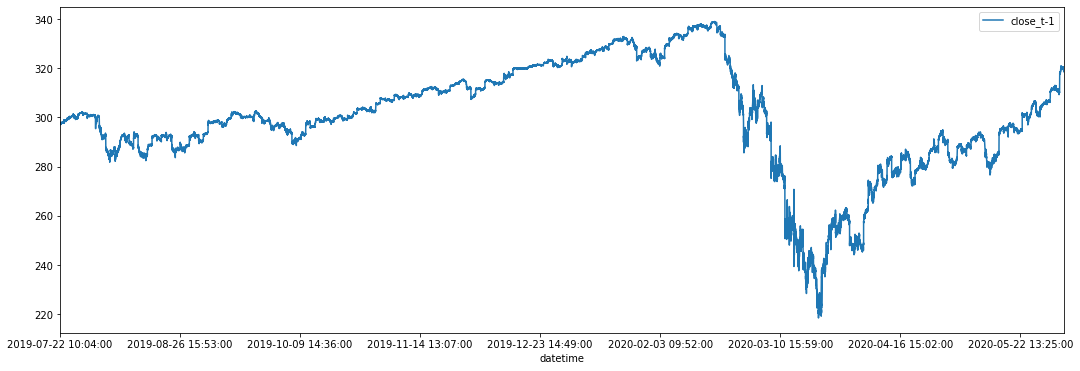

Number of instances: 83656
Class distribution: 
0 in 0.5118700392081859%
1 in 0.4881299607918141%


<IPython.core.display.Javascript object>

Start efts\5min-level\S&P500\spy_alphavantage_2019_2020_no_missing_data_market_hours_no_missing_data.csv
5min-level
               datetime      open    high      low     close    volume  \
33  2019-07-22 12:15:00  297.5700  297.69  297.500  297.6715  127872.0   
34  2019-07-22 12:20:00  297.6800  297.76  297.590  297.7200  298071.0   
35  2019-07-22 12:25:00  297.7300  297.85  297.720  297.7800  205996.0   
36  2019-07-22 12:30:00  297.7722  297.80  297.655  297.6950  738415.0   
37  2019-07-22 12:35:00  297.6900  297.89  297.665  297.8700  269532.0   

    close_t-1  close_t-2  close_t-3  close_t-4  ...  typprice_10  wclprice_10  \
33   297.5800   297.3200   297.3600   297.6530  ...   297.620500    297.63325   
34   297.6715   297.5800   297.3200   297.3600  ...   297.690000    297.69750   
35   297.7200   297.6715   297.5800   297.3200  ...   297.783333    297.78250   
36   297.7800   297.7200   297.6715   297.5800  ...   297.716667    297.71125   
37   297.6950   297.7800   297.720

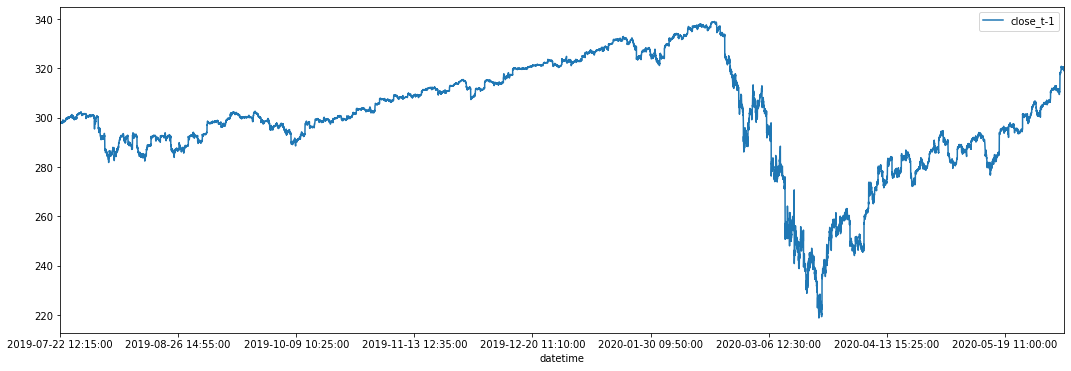

Number of instances: 17008
Class distribution: 
0 in 0.4909454374412041%
1 in 0.5090545625587959%


<IPython.core.display.Javascript object>

Start efts\10min-level\S&P500\spy_alphavantage_2019_2020_no_missing_data_market_hours_no_missing_data.csv
10min-level
               datetime      open     high     low     close     volume  \
33  2019-07-22 15:00:00  297.9500  298.500  297.92  298.2200  1828789.0   
34  2019-07-22 15:10:00  298.2200  298.240  298.07  298.0900   961202.0   
35  2019-07-22 15:20:00  298.0801  298.160  297.82  298.0249   947075.0   
36  2019-07-22 15:30:00  298.0300  298.030  297.66  297.6900  1439055.0   
37  2019-07-22 15:40:00  297.6800  297.825  297.65  297.7701  1096158.0   

    close_t-1  close_t-2  close_t-3  close_t-4  ...  typprice_10  wclprice_10  \
33   297.9550   297.8250    297.790    297.891  ...   298.213333    298.21500   
34   298.2200   297.9550    297.825    297.790  ...   298.133333    298.12250   
35   298.0900   298.2200    297.955    297.825  ...   298.001633    298.00745   
36   298.0249   298.0900    298.220    297.955  ...   297.793333    297.76750   
37   297.6900   298.0249  

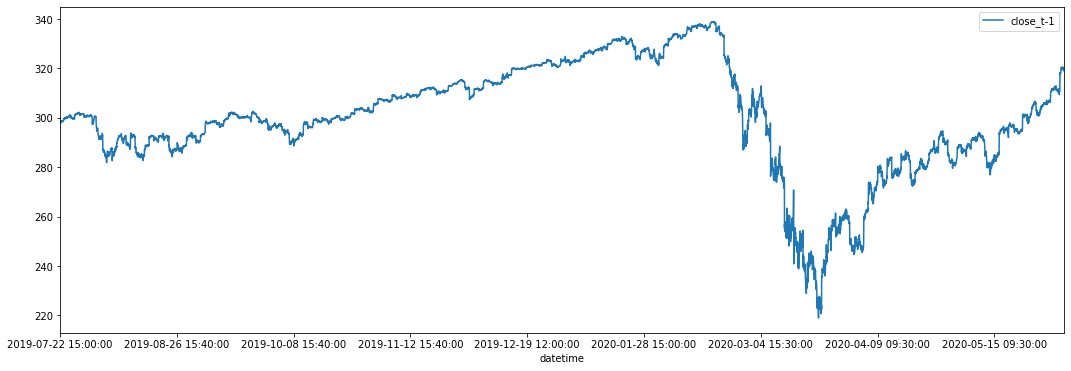

Number of instances: 8599
Class distribution: 
0 in 0.48261425747179904%
1 in 0.5173857425282009%


<IPython.core.display.Javascript object>

Start efts\15min-level\S&P500\spy_alphavantage_2019_2020_no_missing_data_market_hours_no_missing_data.csv
15min-level
               datetime    open      high     low   close     volume  \
33  2019-07-23 11:00:00  298.86  298.8700  298.48  298.64  1157150.0   
34  2019-07-23 11:15:00  298.65  298.9085  298.62  298.62  1802230.0   
35  2019-07-23 11:30:00  298.62  298.6900  298.35  298.53  1297209.0   
36  2019-07-23 11:45:00  298.53  298.5400  298.31  298.47  1176407.0   
37  2019-07-23 12:00:00  298.45  298.5400  298.22  298.52  1047644.0   

    close_t-1  close_t-2  close_t-3  close_t-4  ...  typprice_10  wclprice_10  \
33     298.87     298.79   298.4001   298.4125  ...   298.663333   298.657500   
34     298.64     298.87   298.7900   298.4001  ...   298.716167   298.692125   
35     298.62     298.64   298.8700   298.7900  ...   298.523333   298.525000   
36     298.53     298.62   298.6400   298.8700  ...   298.440000   298.447500   
37     298.47     298.53   298.6200   298.64

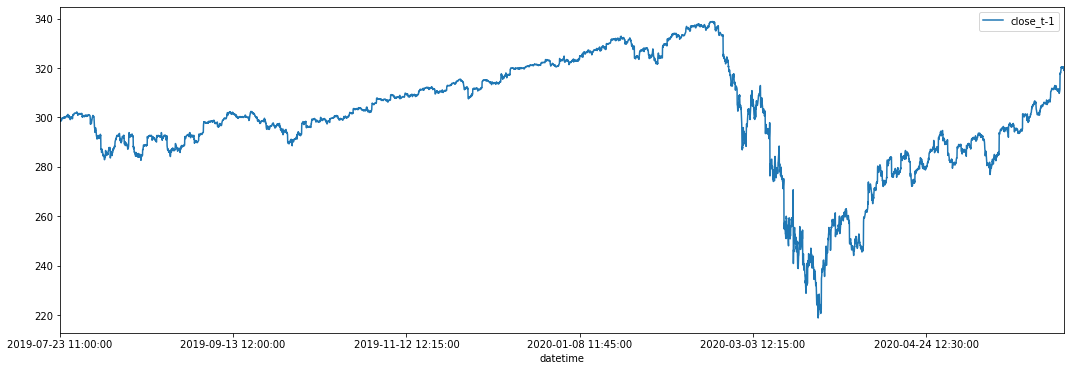

Number of instances: 5797
Class distribution: 
0 in 0.48249094359151284%
1 in 0.5175090564084871%


<IPython.core.display.Javascript object>

Start efts\30min-level\S&P500\spy_alphavantage_2019_2020_no_missing_data_market_hours_no_missing_data.csv
30min-level
               datetime    open    high       low     close     volume  \
33  2019-07-24 12:00:00  299.84  300.19  299.8165  300.1400  2275123.0   
34  2019-07-24 12:30:00  300.14  300.47  300.0500  300.4050  1320701.0   
35  2019-07-24 13:00:00  300.40  300.47  300.3100  300.4100  1838198.0   
36  2019-07-24 13:30:00  300.40  300.45  300.2250  300.4000  1709336.0   
37  2019-07-24 14:00:00  300.41  300.70  300.3900  300.6877  2296647.0   

    close_t-1  close_t-2  close_t-3  close_t-4  ...  typprice_10  wclprice_10  \
33    299.830    299.860    300.070     300.01  ...   300.048833   300.071625   
34    300.140    299.830    299.860     300.07  ...   300.308333   300.332500   
35    300.405    300.140    299.830     299.86  ...   300.396667   300.400000   
36    300.410    300.405    300.140     299.83  ...   300.358333   300.368750   
37    300.400    300.410    300.

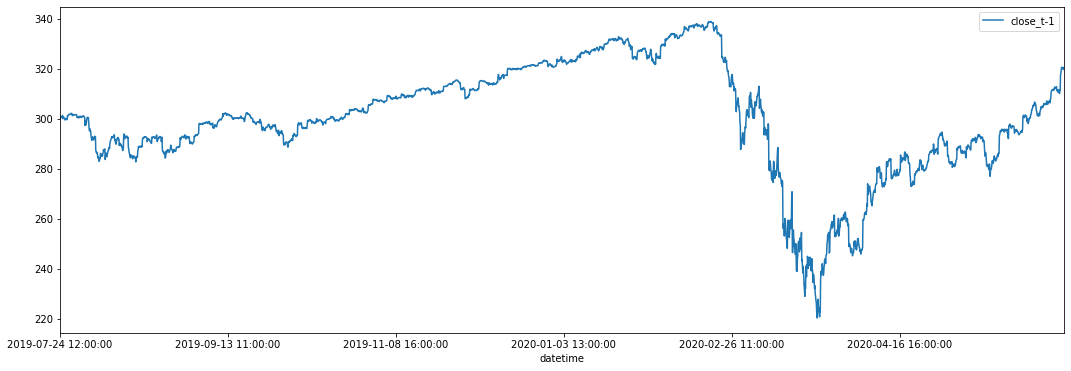

Number of instances: 2990
Class distribution: 
0 in 0.4735785953177257%
1 in 0.5264214046822743%


<IPython.core.display.Javascript object>

In [73]:
# BATCH

# Paths for symbols
DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data'])
SOURCE_PATH=DATA_PATH 
RESULT_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output']) 

for file in files:
    filename = file.replace(SOURCE_PATH+os.sep,'')
    FIELD = 'close' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'
    print(f'Start {filename}')
    level = filename.split(os.sep)[1]
    print(level)

    file = os.sep.join([SOURCE_PATH, filename])
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_'+level+'_indicators_11062020.csv'])
    
    
    # Open file
    df=pd.read_csv(file, sep=';')
    
#     print(df.head())
#     assert False
    df=df.drop_duplicates(['datetime','open','high','low','close','volume']) 
    
    #Add parameters to transform in TS
    timeseries=['close', 'open', 'high', 'low']
    #Length of the TS. How many values do we keep per serie. 
    # e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
    length = 5
    
    # Add lagged times
    for column in timeseries:
        for i in range(1,length):
            df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed


    # all the numbers here and below assume a default time period for ta params of 10 mins averages
    # change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
    # in that case change as well the time tag '_10' with the corresponding one.
    default_timerange=10
    # Set extra timeranges for moving averages
    extra_timeranges=[default_timerange//2, default_timerange, default_timerange*2, default_timerange*3]

    # ###########################################
    # Iterate and run list of indicators selected
    # All of them produced for 25 prior mins of data 
    # ###########################################    
    for ind in list(indicators):
#         print(ind)
        if ind not in ['adosc', 'obv', 'mfi']:  # avoiding indicators that need volume
            # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
            if ind in ['ema','sma','trima']:
                for timerange in extra_timeranges:
#                     print(ind+'_'+str(int(timerange)))
                    df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
            elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
                df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
            # Otherwise check the list of columns and return all
            else: 
                key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
                for j in range(0,len(list(key_output.columns))):
                    df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]
#     for key in list(indicator.keys()):
#         # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
#         if key in ['ema','sma','trima']:
#             df[key+'_'+str(default_timerange//2)]=indicator[key](df, timeperiod=(default_timerange/2)) 
#             df[key+'_'+str(default_timerange)]=indicator[key](df, timeperiod=(default_timerange)) 
#             df[key+'_'+str(default_timerange*2)]=indicator[key](df, timeperiod=(default_timerange*2))     
#         elif key not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
#             df[key+'_'+str(default_timerange)]=indicator[key](df, timeperiod=(default_timerange))
#         # Otherwise check the list of columns and return all
#         else: 
#             key_output=indicator[key](df, timeperiod=(default_timerange)) #, price='close')
#             for j in range(0,len(list(key_output.columns))):
#                 df[key+'_'+key_output.columns[j]] = key_output[key_output.columns[j]]

    def set_label(row):
        if row['close_t+1'] > row['close']: return 1
        else: return 0

    # One minute ahead closing price
    df['close_t+1']=df['close'].shift(-1)
#     df['close_t+1']=df['close'].shift(-1)

#     def func(row):
#         if row['close_t+1'] > row['close']:
#             return 1
#         else:
#             return 0

    # Creating label/y to be predicted / independent (predicted) feature 'y' 
    df['label'] = df.apply(set_label, axis=1)
#     df['label'] = df.apply(func, axis=1)

    df.dropna(inplace=True)
    
    # Select columns for output
    # best pool found through indicators grid search script
    columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                        'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                        'aroon_aroondown','aroon_aroonup','label']
#     columns_selected = ['datetime', 'sma_5','ema_5','sma_20','ema_20','adosc_10','macd_macd','willr_10','stoch_slowk','stoch_slowd','cci_10','ema_10','rsi_10','sma_10','mom_10', 'label']

    # Export processed data
    print(df.head())
    output = pd.DataFrame(df, columns=columns_selected)[df['datetime'] >= '2017-09-25 14:07:00']
    output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
    devsets_path = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\data\\real\\real_financial_data_not_handling_gaps\\dev_sets\\'
#     create_arff_file(RESULT_FILEPATH_PROCESSED) # export in ARFF
    create_arff_file(RESULT_FILEPATH_PROCESSED, output=devsets_path+RESULT_FILEPATH_PROCESSED.split(os.sep)[-1]) # export in ARFF

    # Now plot close price and volume overtime.
    df.set_index('datetime',drop=True).plot(y=["close_t-1"], figsize=(18,6))
    plt.show()    
    
    df = output
    print(f'Number of instances: {len(df)}')
    # Printing classes distributions
    print("Class distribution: ")
    label_zero=len(df[df['label'] == 0])
    label_one=len(df[df['label'] == 1])
    #print(label_zero)
    #print(label_one)
    print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
    print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

    %notify -m "Parsing is finished"    
    
